In [27]:
# Importación de librerías necesarias
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Configuración
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('default')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print("✅ Librerías importadas exitosamente")
print("📊 Configuración de visualización establecida")

✅ Librerías importadas exitosamente
📊 Configuración de visualización establecida


# Análisis Exploratorio de Datos - Medical Expenditure Panel Survey (MEPS) 2022

## Objetivo del Análisis

Este documento presenta un análisis exploratorio formal del dataset MEPS 2022 unificado, enfocado en la predicción de primas out-of-pocket de seguros médicos privados. El análisis se estructura en cinco secciones principales:

1. **Análisis General del Dataset**: Características estructurales y tipos de datos
2. **Variables Demográficas**: Distribuciones y patrones socioeconómicos
3. **Condiciones Médicas**: Análisis de morbilidad y categorías CCSR
4. **Historial de Seguros Médicos**: Coberturas y costos
5. **Historial Laboral**: Características del empleo
6. **Análisis de Correlaciones**: Relaciones entre variables cuantitativas

**Fuente de Datos**: Medical Expenditure Panel Survey (MEPS) 2022 - Agency for Healthcare Research and Quality (AHRQ)

**Variable Objetivo**: Prima out-of-pocket de seguros médicos privados

In [28]:
# Carga del Dataset MEPS 2022 Unificado
print("🔄 Iniciando carga del dataset MEPS 2022 unificado...")

try:
    with open('../meps_2022_unified_reduced.json', 'r', encoding='utf-8') as file:
        meps_data = json.load(file)
    
    print(f"✅ Dataset cargado exitosamente")
    print(f"📊 Total de registros: {len(meps_data):,} individuos")
    
    # Verificar estructura básica
    sample_id = list(meps_data.keys())[0]
    sample_record = meps_data[sample_id]
    
    print(f"\n🔍 Estructura básica del dataset:")
    print(f"   • ID de muestra: {sample_id}")
    print(f"   • Campos por registro: {len(sample_record)} campos principales")
    print(f"   • Condiciones médicas (muestra): {len(sample_record.get('condiciones_medicas', []))}")
    print(f"   • Historial laboral (muestra): {len(sample_record.get('historial_empleo', []))}")
    print(f"   • Historial de seguros (muestra): {len(sample_record.get('historial_seguros', []))}")
    
except FileNotFoundError:
    print("❌ Error: Archivo no encontrado. Verificar ruta del dataset.")
except Exception as e:
    print(f"❌ Error al cargar el dataset: {str(e)}")

🔄 Iniciando carga del dataset MEPS 2022 unificado...
✅ Dataset cargado exitosamente
📊 Total de registros: 11,852 individuos

🔍 Estructura básica del dataset:
   • ID de muestra: 2460010101
   • Campos por registro: 14 campos principales
   • Condiciones médicas (muestra): 5
   • Historial laboral (muestra): 2
   • Historial de seguros (muestra): 1


## 1. Análisis General del Dataset

Esta sección presenta las características estructurales del dataset MEPS 2022, incluyendo tipos de datos, completitud de la información y estadísticas descriptivas generales.

In [29]:
# 1.1 Análisis General del Dataset: Tipos de Datos y Completitud

print("=" * 80)
print("ANÁLISIS GENERAL DEL DATASET MEPS 2022")
print("=" * 80)

# Extraer datos demográficos para análisis de tipos y completitud
demographic_records = []
all_fields = set()

# Primera pasada: identificar todos los campos demográficos
for person_id, person_data in meps_data.items():
    demographic_record = {'person_id': person_id}
    
    for key, value in person_data.items():
        if not isinstance(value, list):  # Solo campos demográficos (no listas)
            demographic_record[key] = value
            all_fields.add(key)
    
    # Agregar conteos de elementos en listas
    demographic_record['num_condiciones'] = len(person_data.get('condiciones_medicas', []))
    demographic_record['num_empleos'] = len(person_data.get('historial_empleo', []))
    demographic_record['num_seguros'] = len(person_data.get('historial_seguros', []))
    
    demographic_records.append(demographic_record)

# Crear DataFrame para análisis
df_analysis = pd.DataFrame(demographic_records)

print(f"📊 ESTADÍSTICAS GENERALES:")
print(f"   • Total de individuos: {len(df_analysis):,}")
print(f"   • Total de variables: {len(df_analysis.columns)}")
print(f"   • Tamaño en memoria: {df_analysis.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Análisis de tipos de datos y valores nulos
field_analysis = []

for column in df_analysis.columns:
    if column != 'person_id':  # Excluir ID
        col_data = df_analysis[column]
        
        # Determinar tipo de dato
        if pd.api.types.is_numeric_dtype(col_data):
            data_type = "Numérico"
            unique_vals = col_data.nunique()
        else:
            data_type = "Categórico"
            unique_vals = col_data.nunique()
        
        # Calcular estadísticas de completitud
        total_count = len(col_data)
        null_count = col_data.isnull().sum()
        non_null_count = total_count - null_count
        completitud_pct = (non_null_count / total_count) * 100
        
        field_analysis.append({
            'Campo': column,
            'Tipo_Dato': data_type,
            'Total_Registros': total_count,
            'Valores_Válidos': non_null_count,
            'Valores_Nulos': null_count,
            'Completitud_Porcentaje': completitud_pct,
            'Valores_Únicos': unique_vals,
            'Cardinalidad': unique_vals / total_count
        })

# Crear tabla de análisis de campos
df_field_analysis = pd.DataFrame(field_analysis)
df_field_analysis = df_field_analysis.sort_values('Valores_Nulos', ascending=False)

print(f"\n📋 RESUMEN DE TIPOS DE DATOS Y COMPLETITUD:")
print(f"   • Variables numéricas: {len(df_field_analysis[df_field_analysis['Tipo_Dato'] == 'Numérico'])}")
print(f"   • Variables categóricas: {len(df_field_analysis[df_field_analysis['Tipo_Dato'] == 'Categórico'])}")
print(f"   • Completitud promedio: {df_field_analysis['Completitud_Porcentaje'].mean():.2f}%")
print(f"   • Campos con datos faltantes: {len(df_field_analysis[df_field_analysis['Valores_Nulos'] > 0])}")

# Mostrar tabla completa formateada
print(f"\n📊 TABLA DETALLADA DE ANÁLISIS DE CAMPOS:")
print("-" * 120)

# Formatear tabla para mejor legibilidad
display_df = df_field_analysis.copy()
display_df['Completitud_Porcentaje'] = display_df['Completitud_Porcentaje'].round(2)
display_df['Cardinalidad'] = display_df['Cardinalidad'].round(4)

# Usar display para mostrar la tabla completa
display(display_df)

# Estadísticas adicionales
print(f"\n🔍 ESTADÍSTICAS ADICIONALES:")
print(f"   • Campo con mayor cardinalidad: {df_field_analysis.loc[df_field_analysis['Cardinalidad'].idxmax(), 'Campo']}")
print(f"   • Campo con menor completitud: {df_field_analysis.loc[df_field_analysis['Completitud_Porcentaje'].idxmin(), 'Campo']} ({df_field_analysis['Completitud_Porcentaje'].min():.2f}%)")
print(f"   • Campos completamente completos: {len(df_field_analysis[df_field_analysis['Valores_Nulos'] == 0])}")

# Guardar DataFrame para análisis posteriores
globals()['df_meps'] = df_analysis
globals()['df_field_info'] = df_field_analysis

print(f"\n✅ Análisis general completado. DataFrames disponibles: 'df_meps' y 'df_field_info'")

ANÁLISIS GENERAL DEL DATASET MEPS 2022
📊 ESTADÍSTICAS GENERALES:
   • Total de individuos: 11,852
   • Total de variables: 15
   • Tamaño en memoria: 6.00 MB

📋 RESUMEN DE TIPOS DE DATOS Y COMPLETITUD:
   • Variables numéricas: 7
   • Variables categóricas: 7
   • Completitud promedio: 100.00%
   • Campos con datos faltantes: 0

📊 TABLA DETALLADA DE ANÁLISIS DE CAMPOS:
------------------------------------------------------------------------------------------------------------------------
📊 ESTADÍSTICAS GENERALES:
   • Total de individuos: 11,852
   • Total de variables: 15
   • Tamaño en memoria: 6.00 MB

📋 RESUMEN DE TIPOS DE DATOS Y COMPLETITUD:
   • Variables numéricas: 7
   • Variables categóricas: 7
   • Completitud promedio: 100.00%
   • Campos con datos faltantes: 0

📊 TABLA DETALLADA DE ANÁLISIS DE CAMPOS:
------------------------------------------------------------------------------------------------------------------------


,Campo,Tipo_Dato,Total_Registros,Valores_Válidos,Valores_Nulos,Completitud_Porcentaje,Valores_Únicos,Cardinalidad
0,edad,Numérico,11852,11852,0,100.0,86,7.30e-03
1,sexo,Categórico,11852,11852,0,100.0,2,2.00e-04
2,raza_etnicidad,Categórico,11852,11852,0,100.0,5,4.00e-04
3,estado_civil,Categórico,11852,11852,0,100.0,6,5.00e-04
4,region,Categórico,11852,11852,0,100.0,5,4.00e-04
5,gastos_medicos_totales,Numérico,11852,11852,0,100.0,6524,5.50e-01
6,gastos_out_of_pocket,Numérico,11852,11852,0,100.0,3238,2.73e-01
7,categoria_pobreza,Categórico,11852,11852,0,100.0,5,4.00e-04
8,cobertura_seguro,Categórico,11852,11852,0,100.0,3,3.00e-04
9,estado_salud_percibido,Categórico,11852,11852,0,100.0,8,7.00e-04



🔍 ESTADÍSTICAS ADICIONALES:
   • Campo con mayor cardinalidad: peso_persona
   • Campo con menor completitud: edad (100.00%)
   • Campos completamente completos: 14

✅ Análisis general completado. DataFrames disponibles: 'df_meps' y 'df_field_info'


## 2. Análisis de Variables Demográficas

Esta sección examina las características demográficas de la población de estudio, incluyendo distribuciones por edad, sexo, raza/etnicidad, estado civil, región geográfica y categoría socioeconómica.

### Matriz de Correlación (Incluyendo Prima Out-of-Pocket)

La siguiente tabla muestra la correlación entre las variables principales del dataset, incluyendo la variable objetivo `prima_out_of_pocket_editada`. Esto permite identificar qué variables tienen mayor relación lineal con la prima y pueden ser relevantes para el modelo predictivo.

ANÁLISIS DE VARIABLES DEMOGRÁFICAS
📊 Variables demográficas disponibles: 6
   Variables: edad, sexo, raza_etnicidad, estado_civil, region, categoria_pobreza

👥 ANÁLISIS DE EDAD:

   Estadísticas Descriptivas de Edad:


,Estadística,Valor
0,Media,42.41
1,Mediana,43.00
2,Desviación Estándar,21.58
3,Mínimo,0.00
4,Máximo,85.00
5,Q1 (25%),26.00
6,Q3 (75%),60.00



   Distribución por Grupos Etarios:


,Grupo_Etario,Frecuencia,Porcentaje
0,0-17,2097,17.69
1,18-34,2388,20.15
2,35-49,2650,22.36
3,50-64,2919,24.63
4,65+,1787,15.08



📋 ANÁLISIS DE SEXO:
   Total de categorías: 2
   Categoría más frecuente: Female (51.6%)
   Distribución:


,Categoría,Frecuencia,Porcentaje
0,Female,6119,51.63
1,Male,5733,48.37



📋 ANÁLISIS DE RAZA ETNICIDAD:
   Total de categorías: 5
   Categoría más frecuente: Non-Hispanic White only (63.6%)
   Distribución:


,Categoría,Frecuencia,Porcentaje
0,Non-Hispanic White only,7534,63.57
1,Hispanic,1687,14.23
2,Non-Hispanic Black only,1316,11.10
3,Non-Hispanic Asian only,861,7.26
4,Non-Hispanic Other race or multi-race,454,3.83



📋 ANÁLISIS DE ESTADO CIVIL:
   Total de categorías: 6
   Categoría más frecuente: Married (47.9%)
   Distribución:


,Categoría,Frecuencia,Porcentaje
0,Married,5679,47.92
1,Never married,2704,22.81
2,Under 16 - not applicable,1728,14.58
3,Divorced,1108,9.35
4,Widowed,494,4.17
5,Separated,139,1.17



📋 ANÁLISIS DE REGION:
   Total de categorías: 5
   Categoría más frecuente: South (34.3%)
   Distribución:


,Categoría,Frecuencia,Porcentaje
0,South,4067,34.31
1,West,3113,26.27
2,Midwest,2649,22.35
3,Northeast,1974,16.66
4,Inapplicable,49,0.41



📋 ANÁLISIS DE CATEGORIA POBREZA:
   Total de categorías: 5
   Categoría más frecuente: High income (55.3%)
   Distribución:


,Categoría,Frecuencia,Porcentaje
0,High income,6549,55.26
1,Middle income,3586,30.26
2,Low income,968,8.17
3,Poor/negative,561,4.73
4,Near poor,188,1.59



🔗 ANÁLISIS DE CORRELACIONES DEMOGRÁFICAS:
   Correlaciones significativas (|r| > 0.3):


,Variable_1,Variable_2,Correlación,Fuerza
1,gastos_medicos_totales,gastos_out_of_pocket,0.47,Moderada
0,edad,num_condiciones,0.45,Moderada
2,gastos_medicos_totales,num_condiciones,0.31,Moderada


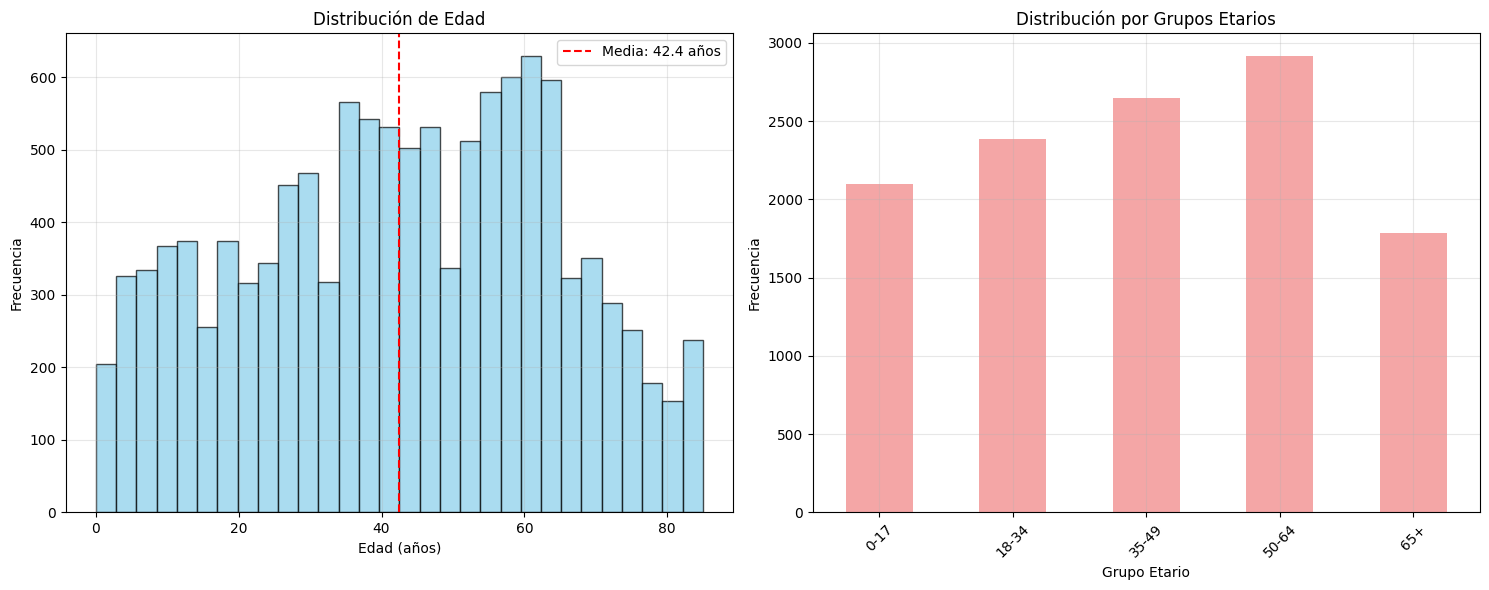


✅ Análisis demográfico completado.
📊 Resumen: 11852 individuos analizados en 6 variables demográficas


In [30]:
# 2.1 Análisis Detallado de Variables Demográficas

print("=" * 80)
print("ANÁLISIS DE VARIABLES DEMOGRÁFICAS")
print("=" * 80)

# Variables demográficas de interés
demographic_vars = ['edad', 'sexo', 'raza_etnicidad', 'estado_civil', 'region', 'categoria_pobreza']
available_demo_vars = [var for var in demographic_vars if var in df_meps.columns]

print(f"📊 Variables demográficas disponibles: {len(available_demo_vars)}")
print(f"   Variables: {', '.join(available_demo_vars)}")

# 2.1.1 Análisis de Edad
if 'edad' in df_meps.columns:
    print(f"\n👥 ANÁLISIS DE EDAD:")
    edad_stats = df_meps['edad'].describe()
    
    # Crear tabla de estadísticas descriptivas de edad
    edad_summary = pd.DataFrame({
        'Estadística': ['Media', 'Mediana', 'Desviación Estándar', 'Mínimo', 'Máximo', 'Q1 (25%)', 'Q3 (75%)'],
        'Valor': [
            edad_stats['mean'],
            edad_stats['50%'],
            edad_stats['std'],
            edad_stats['min'],
            edad_stats['max'],
            edad_stats['25%'],
            edad_stats['75%']
        ]
    })
    edad_summary['Valor'] = edad_summary['Valor'].round(2)
    
    print("\n   Estadísticas Descriptivas de Edad:")
    display(edad_summary)
    
    # Crear grupos etarios para análisis
    df_meps['grupo_etario'] = pd.cut(df_meps['edad'], 
                                   bins=[0, 18, 35, 50, 65, 100], 
                                   labels=['0-17', '18-34', '35-49', '50-64', '65+'])
    
    grupos_etarios = df_meps['grupo_etario'].value_counts().sort_index()
    grupos_etarios_pct = (grupos_etarios / len(df_meps) * 100).round(2)
    
    tabla_grupos = pd.DataFrame({
        'Grupo_Etario': grupos_etarios.index,
        'Frecuencia': grupos_etarios.values,
        'Porcentaje': grupos_etarios_pct.values
    })
    
    print("\n   Distribución por Grupos Etarios:")
    display(tabla_grupos)

# 2.1.2 Análisis de variables categóricas
for var in available_demo_vars:
    if var != 'edad' and var in df_meps.columns:
        print(f"\n📋 ANÁLISIS DE {var.upper().replace('_', ' ')}:")
        
        # Calcular frecuencias
        freq_table = df_meps[var].value_counts()
        freq_pct = (freq_table / len(df_meps) * 100).round(2)
        
        # Crear tabla resumen
        summary_table = pd.DataFrame({
            'Categoría': freq_table.index,
            'Frecuencia': freq_table.values,
            'Porcentaje': freq_pct.values
        })
        
        print(f"   Total de categorías: {len(freq_table)}")
        print(f"   Categoría más frecuente: {freq_table.index[0]} ({freq_pct.iloc[0]:.1f}%)")
        print(f"   Distribución:")
        display(summary_table)

# 2.1.3 Análisis de correlaciones demográficas
print(f"\n🔗 ANÁLISIS DE CORRELACIONES DEMOGRÁFICAS:")

# Seleccionar variables numéricas para correlación
numeric_demo_vars = df_meps.select_dtypes(include=[np.number]).columns.tolist()
numeric_demo_vars = [var for var in numeric_demo_vars if var not in ['person_id', 'id_persona']]

if len(numeric_demo_vars) >= 2:
    demo_corr_matrix = df_meps[numeric_demo_vars].corr()
    
    # Encontrar correlaciones significativas (>0.3)
    correlaciones_significativas = []
    for i in range(len(demo_corr_matrix.columns)):
        for j in range(i+1, len(demo_corr_matrix.columns)):
            corr_val = demo_corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.3:
                correlaciones_significativas.append({
                    'Variable_1': demo_corr_matrix.columns[i],
                    'Variable_2': demo_corr_matrix.columns[j],
                    'Correlación': round(corr_val, 3),
                    'Fuerza': 'Fuerte' if abs(corr_val) > 0.7 else 'Moderada'
                })
    
    if correlaciones_significativas:
        df_corr_sig = pd.DataFrame(correlaciones_significativas)
        df_corr_sig = df_corr_sig.sort_values('Correlación', key=abs, ascending=False)
        print("   Correlaciones significativas (|r| > 0.3):")
        display(df_corr_sig)
    else:
        print("   No se encontraron correlaciones significativas entre variables demográficas.")

# Crear visualización de edad si está disponible
if 'edad' in df_meps.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histograma de edad
    ax1.hist(df_meps['edad'].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(df_meps['edad'].mean(), color='red', linestyle='--', 
                label=f'Media: {df_meps["edad"].mean():.1f} años')
    ax1.set_xlabel('Edad (años)')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title('Distribución de Edad')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico de barras de grupos etarios
    if 'grupo_etario' in df_meps.columns:
        grupos_etarios.plot(kind='bar', ax=ax2, color='lightcoral', alpha=0.7)
        ax2.set_xlabel('Grupo Etario')
        ax2.set_ylabel('Frecuencia')
        ax2.set_title('Distribución por Grupos Etarios')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print(f"\n✅ Análisis demográfico completado.")
print(f"📊 Resumen: {len(df_meps)} individuos analizados en {len(available_demo_vars)} variables demográficas")

# Matriz de correlación incluyendo Prima Out-of-Pocket Editada
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar variables numéricas relevantes, incluyendo la prima editada
cols_corr = [
    'edad', 'gastos_medicos_totales', 'gastos_out_of_pocket', 'peso_persona',
    'num_condiciones', 'prima_out_of_pocket_editada'
]



## 3. Análisis de Condiciones Médicas

Esta sección examina las condiciones de salud de la población de estudio, incluyendo categorías CCSR, estado de salud percibido, edad de diagnóstico y patrones de morbilidad.

ANÁLISIS DE CONDICIONES MÉDICAS Y ESTADO DE SALUD
📊 ESTADÍSTICAS GENERALES DE CONDICIONES MÉDICAS:
   • Total de registros de condiciones: 25,658
   • Personas con información de estado de salud: 11,852
   • Personas con condiciones registradas: 7,649

🏥 ANÁLISIS DE ESTADO DE SALUD PERCIBIDO:
   Distribución del Estado de Salud Percibido:


,Estado_Salud,Frecuencia,Porcentaje
0,Very good,4400,37.12
1,Good,3211,27.09
2,Excellent,3167,26.72
3,Fair,807,6.81
4,Poor,173,1.46
5,Inapplicable,63,0.53
6,Refused,21,0.18
7,Don't know,10,0.08



🔬 ANÁLISIS DE CATEGORÍAS CCSR:
   • Total de categorías CCSR únicas: 184
   • Categorías más frecuentes (Top 15):


,Categoría_CCSR,Frecuencia,Porcentaje_Total
0,Essential hypertension,2391,9.32
1,Disorders of lipid metabolism,1799,7.01
2,Categoría médica no especificada,1269,4.95
3,Anxiety and fear-related disorders,894,3.48
4,Diabetes mellitus without complication,890,3.47
5,"Exposure, encounters, screening or contact wit...",886,3.45
6,"Musculoskeletal pain, not low back pain",837,3.26
7,Depressive disorders,715,2.79
8,Asthma,685,2.67
9,Thyroid disorders,676,2.63



   📈 Estadísticas de Condiciones por Persona:


,Estadística,Valor
0,Media,3.35
1,Mediana,2.00
2,Desv. Estándar,2.91
3,Mínimo,1.00
4,Máximo,29.00
5,Q1,1.00
6,Q3,4.00



📅 ANÁLISIS DE EDAD DE DIAGNÓSTICO:
   • Registros con edad de diagnóstico válida: 6,655
   Estadísticas de Edad al Diagnóstico:


,Estadística,Edad_años
0,Media,46.1
1,Mediana,50.0
2,Desv. Estándar,17.6
3,Mínimo,0.0
4,Máximo,85.0
5,Q1,37.0
6,Q3,58.0



🩹 ANÁLISIS DE LESIONES:
   Distribución de Condiciones por Tipo (Lesión vs No Lesión):


,Es_Lesión,Frecuencia,Porcentaje
0,No,7091,27.64



📆 ANÁLISIS TEMPORAL POR ROUNDS:
   Distribución de Condiciones por Round de Reporte:


,Round,Condiciones_Reportadas,Porcentaje
0,1,16022,62.44
1,2,2218,8.64
2,3,4070,15.86
3,4,404,1.57
4,5,497,1.94
5,6,603,2.35
6,7,1844,7.19


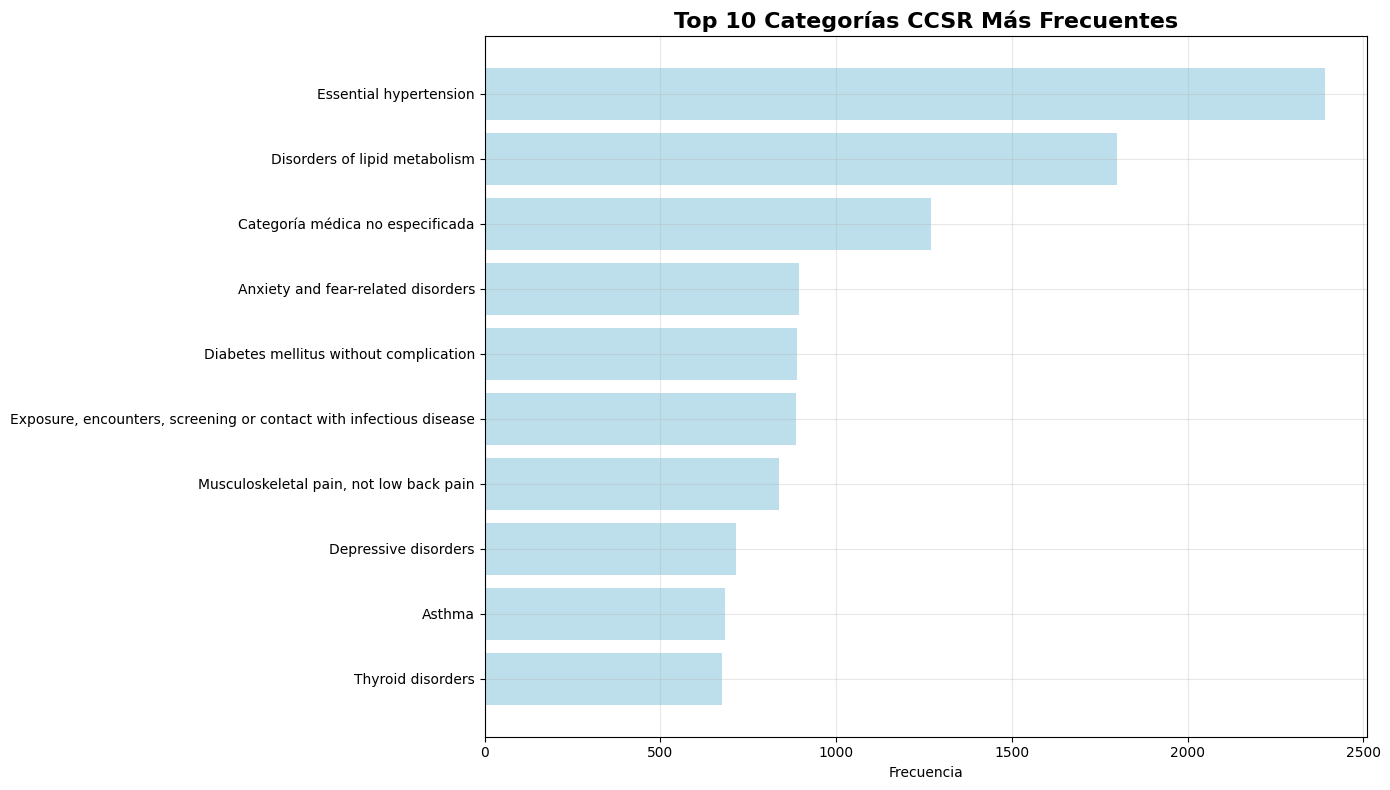


🔗 INTEGRACIÓN CON DATOS DEMOGRÁFICOS:
   • Distribución de número de condiciones en el dataset principal:


,Estadística,Número_Condiciones
0,Media,2.16
1,Mediana,1.00
2,Desv. Estándar,2.83
3,Mínimo,0.00
4,Máximo,29.00



✅ Análisis de condiciones médicas completado.
📊 Resumen: 25,658 condiciones analizadas de 7,649 individuos


In [31]:
# 3.1 Análisis Detallado de Condiciones Médicas

print("=" * 80)
print("ANÁLISIS DE CONDICIONES MÉDICAS Y ESTADO DE SALUD")
print("=" * 80)

# Extraer todas las condiciones médicas del dataset
condiciones_data = []
estado_salud_data = []

for person_id, person_data in meps_data.items():
    # Estado de salud percibido
    if 'estado_salud_percibido' in person_data:
        estado_salud_data.append({
            'person_id': person_id,
            'estado_salud_percibido': person_data['estado_salud_percibido']
        })
    
    # Condiciones médicas
    condiciones = person_data.get('condiciones_medicas', [])
    for condicion in condiciones:
        if isinstance(condicion, dict):
            condicion_record = condicion.copy()
            condicion_record['person_id'] = person_id
            condiciones_data.append(condicion_record)

# Crear DataFrames
df_condiciones = pd.DataFrame(condiciones_data)
df_estado_salud = pd.DataFrame(estado_salud_data)

print(f"📊 ESTADÍSTICAS GENERALES DE CONDICIONES MÉDICAS:")
print(f"   • Total de registros de condiciones: {len(df_condiciones):,}")
print(f"   • Personas con información de estado de salud: {len(df_estado_salud):,}")
print(f"   • Personas con condiciones registradas: {df_condiciones['person_id'].nunique():,}")

# 3.1.1 Análisis de Estado de Salud Percibido
if not df_estado_salud.empty and 'estado_salud_percibido' in df_estado_salud.columns:
    print(f"\n🏥 ANÁLISIS DE ESTADO DE SALUD PERCIBIDO:")
    
    salud_freq = df_estado_salud['estado_salud_percibido'].value_counts()
    salud_pct = (salud_freq / len(df_estado_salud) * 100).round(2)
    
    tabla_salud = pd.DataFrame({
        'Estado_Salud': salud_freq.index,
        'Frecuencia': salud_freq.values,
        'Porcentaje': salud_pct.values
    })
    
    print(f"   Distribución del Estado de Salud Percibido:")
    display(tabla_salud)

# 3.1.2 Análisis de Categorías CCSR
if not df_condiciones.empty and 'descripcion_ccsr' in df_condiciones.columns:
    print(f"\n🔬 ANÁLISIS DE CATEGORÍAS CCSR:")
    
    ccsr_freq = df_condiciones['descripcion_ccsr'].value_counts()
    print(f"   • Total de categorías CCSR únicas: {len(ccsr_freq)}")
    print(f"   • Categorías más frecuentes (Top 15):")
    
    # Top 15 categorías CCSR
    top_ccsr = ccsr_freq.head(15)
    top_ccsr_pct = (top_ccsr / len(df_condiciones) * 100).round(2)
    
    tabla_top_ccsr = pd.DataFrame({
        'Categoría_CCSR': top_ccsr.index,
        'Frecuencia': top_ccsr.values,
        'Porcentaje_Total': top_ccsr_pct.values
    })
    
    display(tabla_top_ccsr)
    
    # Análisis de diversidad de condiciones por persona
    condiciones_por_persona = df_condiciones.groupby('person_id').size()
    
    print(f"\n   📈 Estadísticas de Condiciones por Persona:")
    stats_condiciones = condiciones_por_persona.describe()
    
    tabla_stats_condiciones = pd.DataFrame({
        'Estadística': ['Media', 'Mediana', 'Desv. Estándar', 'Mínimo', 'Máximo', 'Q1', 'Q3'],
        'Valor': [
            stats_condiciones['mean'],
            stats_condiciones['50%'],
            stats_condiciones['std'],
            stats_condiciones['min'],
            stats_condiciones['max'],
            stats_condiciones['25%'],
            stats_condiciones['75%']
        ]
    })
    tabla_stats_condiciones['Valor'] = tabla_stats_condiciones['Valor'].round(2)
    
    display(tabla_stats_condiciones)

# 3.1.3 Análisis de Edad de Diagnóstico
if not df_condiciones.empty and 'edad_diagnostico' in df_condiciones.columns:
    print(f"\n📅 ANÁLISIS DE EDAD DE DIAGNÓSTICO:")
    
    # Filtrar edades válidas
    edades_validas = df_condiciones[
        (df_condiciones['edad_diagnostico'] != 'Inapplicable') & 
        (df_condiciones['edad_diagnostico'].notna())
    ]['edad_diagnostico']
    
    # Convertir a numérico
    try:
        edades_numericas = pd.to_numeric(edades_validas, errors='coerce').dropna()
        
        if len(edades_numericas) > 0:
            print(f"   • Registros con edad de diagnóstico válida: {len(edades_numericas):,}")
            
            stats_edad_dx = edades_numericas.describe()
            tabla_edad_dx = pd.DataFrame({
                'Estadística': ['Media', 'Mediana', 'Desv. Estándar', 'Mínimo', 'Máximo', 'Q1', 'Q3'],
                'Edad_años': [
                    stats_edad_dx['mean'],
                    stats_edad_dx['50%'],
                    stats_edad_dx['std'],
                    stats_edad_dx['min'],
                    stats_edad_dx['max'],
                    stats_edad_dx['25%'],
                    stats_edad_dx['75%']
                ]
            })
            tabla_edad_dx['Edad_años'] = tabla_edad_dx['Edad_años'].round(1)
            
            print(f"   Estadísticas de Edad al Diagnóstico:")
            display(tabla_edad_dx)
        else:
            print(f"   • No se encontraron edades de diagnóstico válidas para análisis numérico")
    
    except Exception as e:
        print(f"   • Error al procesar edades de diagnóstico: {str(e)}")

# 3.1.4 Análisis de Lesiones
if not df_condiciones.empty and 'es_lesion' in df_condiciones.columns:
    print(f"\n🩹 ANÁLISIS DE LESIONES:")
    
    lesiones_freq = df_condiciones['es_lesion'].value_counts()
    lesiones_pct = (lesiones_freq / len(df_condiciones) * 100).round(2)
    
    tabla_lesiones = pd.DataFrame({
        'Es_Lesión': lesiones_freq.index,
        'Frecuencia': lesiones_freq.values,
        'Porcentaje': lesiones_pct.values
    })
    
    print(f"   Distribución de Condiciones por Tipo (Lesión vs No Lesión):")
    display(tabla_lesiones)

# 3.1.5 Análisis Temporal (Rounds)
if not df_condiciones.empty and 'round_reportado' in df_condiciones.columns:
    print(f"\n📆 ANÁLISIS TEMPORAL POR ROUNDS:")
    
    rounds_freq = df_condiciones['round_reportado'].value_counts().sort_index()
    rounds_pct = (rounds_freq / len(df_condiciones) * 100).round(2)
    
    tabla_rounds = pd.DataFrame({
        'Round': rounds_freq.index,
        'Condiciones_Reportadas': rounds_freq.values,
        'Porcentaje': rounds_pct.values
    })
    
    print(f"   Distribución de Condiciones por Round de Reporte:")
    display(tabla_rounds)

# Visualizaciones
if not df_condiciones.empty:
    # Gráfico de top 10 categorías CCSR
    if 'descripcion_ccsr' in df_condiciones.columns:
        plt.figure(figsize=(14, 8))
        top_10_ccsr = ccsr_freq.head(10)
        
        plt.barh(range(len(top_10_ccsr)), top_10_ccsr.values[::-1], 
                 color='lightblue', alpha=0.8)
        plt.yticks(range(len(top_10_ccsr)), top_10_ccsr.index[::-1])
        plt.xlabel('Frecuencia')
        plt.title('Top 10 Categorías CCSR Más Frecuentes', fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Combinar con datos demográficos para análisis integrado
if 'num_condiciones' in df_meps.columns:
    print(f"\n🔗 INTEGRACIÓN CON DATOS DEMOGRÁFICOS:")
    print(f"   • Distribución de número de condiciones en el dataset principal:")
    
    num_cond_stats = df_meps['num_condiciones'].describe()
    tabla_num_cond = pd.DataFrame({
        'Estadística': ['Media', 'Mediana', 'Desv. Estándar', 'Mínimo', 'Máximo'],
        'Número_Condiciones': [
            num_cond_stats['mean'],
            num_cond_stats['50%'],
            num_cond_stats['std'],
            num_cond_stats['min'],
            num_cond_stats['max']
        ]
    })
    tabla_num_cond['Número_Condiciones'] = tabla_num_cond['Número_Condiciones'].round(2)
    
    display(tabla_num_cond)

print(f"\n✅ Análisis de condiciones médicas completado.")
print(f"📊 Resumen: {len(df_condiciones):,} condiciones analizadas de {df_condiciones['person_id'].nunique():,} individuos")

## 4. Análisis de Historial de Seguros Médicos

Esta sección examina las características de la cobertura de seguros médicos, incluyendo tipos de cobertura, primas out-of-pocket (variable objetivo) y patrones temporales de aseguramiento.

ANÁLISIS DE HISTORIAL DE SEGUROS MÉDICOS
📊 ESTADÍSTICAS GENERALES DE SEGUROS:
   • Total de registros de seguros: 12,607
   • Personas con historial de seguros: 11,852

🏥 ANÁLISIS DE COBERTURA DE SEGUROS:
   Distribución por Tipo de Cobertura:


,Tipo_Cobertura,Frecuencia,Porcentaje
0,Yes,7340,58.22
1,No,5267,41.78



💰 ANÁLISIS DE PRIMAS OUT-OF-POCKET (VARIABLE OBJETIVO):
   • Registros con primas válidas: 8,950 de 12,607 (71.0%)
   Estadísticas Descriptivas de Primas Out-of-Pocket:


,Estadística,Prima_USD
0,Media,283.21
1,Mediana,183.00
2,Desv. Estándar,436.55
3,Mínimo,0.00
4,Máximo,15210.00
5,Q1 (25%),35.00
6,Q3 (75%),400.00



   Distribución por Rangos de Primas:


,Rango_Prima,Frecuencia,Porcentaje
0,$0-100,1413,15.79
1,$101-300,2609,29.15
2,$301-600,2047,22.87
3,$601-1000,724,8.09
4,$1000+,307,3.43



📝 ANÁLISIS DE PRIMAS EDITADAS:
   • Registros con primas editadas: 12,607
   Estadísticas de Primas Editadas:


,Estadística,Prima_Editada_USD
0,Media,304.01
1,Mediana,210.00
2,Desv. Estándar,337.15
3,Mínimo,0.00
4,Máximo,4583.33



📆 ANÁLISIS TEMPORAL DE SEGUROS:
   Distribución de Registros de Seguros por Round:


,Round,Registros_Seguros,Porcentaje
0,1,5598,44.40
1,3,4128,32.74
2,7,2881,22.85



   Primas Promedio por Round:


,round_reportado,Prima_Promedio_USD,Num_Registros
0,1,305.31,3965
1,3,288.10,2927
2,7,233.68,2058



🔗 ANÁLISIS DE CONSISTENCIA DE COBERTURA:
   Distribución de Cobertura General:


,Cobertura_General,Frecuencia,Porcentaje
0,Any private,12457,98.81
1,Public only,97,0.77
2,Uninsured,53,0.42


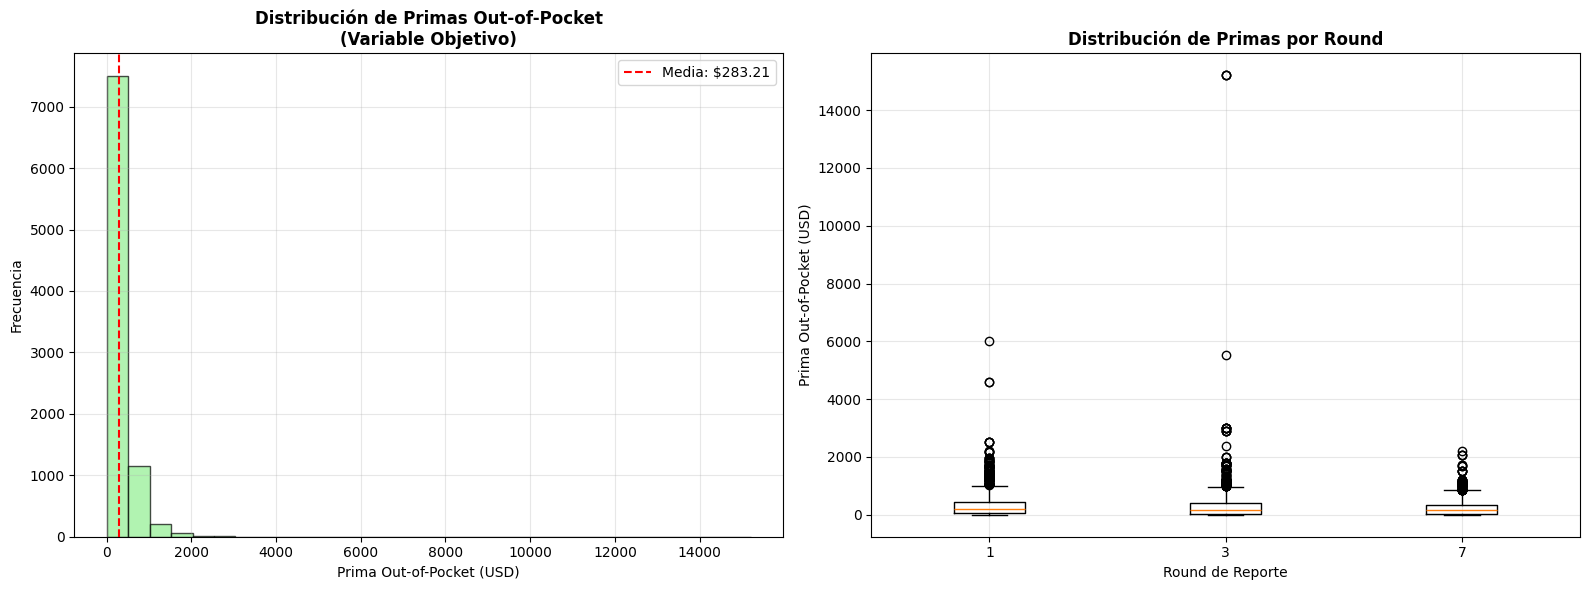


🔗 INTEGRACIÓN CON DATASET PRINCIPAL:
   Estadísticas de Número de Registros de Seguros por Persona:


,Estadística,Número_Registros_Seguros
0,Media,1.06
1,Mediana,1.00
2,Desv. Estándar,0.26
3,Mínimo,1.00
4,Máximo,4.00



✅ Análisis de seguros médicos completado.
📊 Resumen: 12,607 registros de seguros de 11,852 individuos
💰 Variable objetivo: 8,950 primas válidas con promedio de $283.21


In [32]:
# 4.1 Análisis Detallado de Seguros Médicos

print("=" * 80)
print("ANÁLISIS DE HISTORIAL DE SEGUROS MÉDICOS")
print("=" * 80)

# Extraer datos de seguros médicos
seguros_data = []

for person_id, person_data in meps_data.items():
    # Información de cobertura general
    cobertura_general = person_data.get('cobertura_seguro', None)
    
    # Historial detallado de seguros
    historial_seguros = person_data.get('historial_seguros', [])
    
    for seguro in historial_seguros:
        if isinstance(seguro, dict):
            seguro_record = seguro.copy()
            seguro_record['person_id'] = person_id
            seguro_record['cobertura_general'] = cobertura_general
            seguros_data.append(seguro_record)

# Crear DataFrame
df_seguros = pd.DataFrame(seguros_data)

print(f"📊 ESTADÍSTICAS GENERALES DE SEGUROS:")
print(f"   • Total de registros de seguros: {len(df_seguros):,}")
print(f"   • Personas con historial de seguros: {df_seguros['person_id'].nunique():,}")

if not df_seguros.empty:
    # 4.1.1 Análisis de Cobertura de Seguros
    print(f"\n🏥 ANÁLISIS DE COBERTURA DE SEGUROS:")
    
    if 'cobertura_seguro' in df_seguros.columns:
        cobertura_freq = df_seguros['cobertura_seguro'].value_counts()
        cobertura_pct = (cobertura_freq / len(df_seguros) * 100).round(2)
        
        tabla_cobertura = pd.DataFrame({
            'Tipo_Cobertura': cobertura_freq.index,
            'Frecuencia': cobertura_freq.values,
            'Porcentaje': cobertura_pct.values
        })
        
        print(f"   Distribución por Tipo de Cobertura:")
        display(tabla_cobertura)
    
    # 4.1.2 Análisis de Primas Out-of-Pocket (VARIABLE OBJETIVO)
    print(f"\n💰 ANÁLISIS DE PRIMAS OUT-OF-POCKET (VARIABLE OBJETIVO):")
    
    if 'prima_out_of_pocket' in df_seguros.columns:
        # Filtrar valores válidos (no 'Inapplicable' y convertibles a numérico)
        primas_validas = df_seguros[df_seguros['prima_out_of_pocket'] != 'Inapplicable']['prima_out_of_pocket']
        primas_numericas = pd.to_numeric(primas_validas, errors='coerce').dropna()
        
        if len(primas_numericas) > 0:
            print(f"   • Registros con primas válidas: {len(primas_numericas):,} de {len(df_seguros):,} ({(len(primas_numericas)/len(df_seguros)*100):.1f}%)")
            
            # Estadísticas descriptivas de primas
            stats_primas = primas_numericas.describe()
            
            tabla_primas = pd.DataFrame({
                'Estadística': ['Media', 'Mediana', 'Desv. Estándar', 'Mínimo', 'Máximo', 'Q1 (25%)', 'Q3 (75%)'],
                'Prima_USD': [
                    stats_primas['mean'],
                    stats_primas['50%'],
                    stats_primas['std'],
                    stats_primas['min'],
                    stats_primas['max'],
                    stats_primas['25%'],
                    stats_primas['75%']
                ]
            })
            tabla_primas['Prima_USD'] = tabla_primas['Prima_USD'].round(2)
            
            print(f"   Estadísticas Descriptivas de Primas Out-of-Pocket:")
            display(tabla_primas)
            
            # Análisis de distribución por rangos
            rangos_primas = pd.cut(primas_numericas, 
                                 bins=[0, 100, 300, 600, 1000, float('inf')], 
                                 labels=['$0-100', '$101-300', '$301-600', '$601-1000', '$1000+'])
            
            rangos_freq = rangos_primas.value_counts().sort_index()
            rangos_pct = (rangos_freq / len(primas_numericas) * 100).round(2)
            
            tabla_rangos = pd.DataFrame({
                'Rango_Prima': rangos_freq.index,
                'Frecuencia': rangos_freq.values,
                'Porcentaje': rangos_pct.values
            })
            
            print(f"\n   Distribución por Rangos de Primas:")
            display(tabla_rangos)
            
        else:
            print(f"   • No se encontraron primas válidas para análisis numérico")
    
    # 4.1.3 Análisis de Primas Editadas
    if 'prima_out_of_pocket_editada' in df_seguros.columns:
        print(f"\n📝 ANÁLISIS DE PRIMAS EDITADAS:")
        
        # Comparar primas originales vs editadas
        primas_editadas_validas = df_seguros[df_seguros['prima_out_of_pocket_editada'] != 'Inapplicable']['prima_out_of_pocket_editada']
        primas_editadas_numericas = pd.to_numeric(primas_editadas_validas, errors='coerce').dropna()
        
        if len(primas_editadas_numericas) > 0:
            print(f"   • Registros con primas editadas: {len(primas_editadas_numericas):,}")
            
            stats_editadas = primas_editadas_numericas.describe()
            
            tabla_editadas = pd.DataFrame({
                'Estadística': ['Media', 'Mediana', 'Desv. Estándar', 'Mínimo', 'Máximo'],
                'Prima_Editada_USD': [
                    stats_editadas['mean'],
                    stats_editadas['50%'],
                    stats_editadas['std'],
                    stats_editadas['min'],
                    stats_editadas['max']
                ]
            })
            tabla_editadas['Prima_Editada_USD'] = tabla_editadas['Prima_Editada_USD'].round(2)
            
            print(f"   Estadísticas de Primas Editadas:")
            display(tabla_editadas)
    
    # 4.1.4 Análisis Temporal por Rounds
    if 'round_reportado' in df_seguros.columns:
        print(f"\n📆 ANÁLISIS TEMPORAL DE SEGUROS:")
        
        rounds_seguros = df_seguros['round_reportado'].value_counts().sort_index()
        rounds_pct = (rounds_seguros / len(df_seguros) * 100).round(2)
        
        tabla_rounds_seguros = pd.DataFrame({
            'Round': rounds_seguros.index,
            'Registros_Seguros': rounds_seguros.values,
            'Porcentaje': rounds_pct.values
        })
        
        print(f"   Distribución de Registros de Seguros por Round:")
        display(tabla_rounds_seguros)
        
        # Análisis de primas por round
        if len(primas_numericas) > 0:
            df_seguros['prima_numerica'] = pd.to_numeric(df_seguros['prima_out_of_pocket'], errors='coerce')
            primas_por_round = df_seguros.groupby('round_reportado')['prima_numerica'].agg(['mean', 'count']).round(2)
            primas_por_round.columns = ['Prima_Promedio_USD', 'Num_Registros']
            
            print(f"\n   Primas Promedio por Round:")
            display(primas_por_round.reset_index())
    
    # 4.1.5 Análisis de Cobertura General vs Detallada
    if 'cobertura_general' in df_seguros.columns:
        print(f"\n🔗 ANÁLISIS DE CONSISTENCIA DE COBERTURA:")
        
        cobertura_general_freq = df_seguros['cobertura_general'].value_counts()
        cobertura_general_pct = (cobertura_general_freq / len(df_seguros) * 100).round(2)
        
        tabla_cob_general = pd.DataFrame({
            'Cobertura_General': cobertura_general_freq.index,
            'Frecuencia': cobertura_general_freq.values,
            'Porcentaje': cobertura_general_pct.values
        })
        
        print(f"   Distribución de Cobertura General:")
        display(tabla_cob_general)

# Visualizaciones
if not df_seguros.empty and len(primas_numericas) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histograma de primas
    ax1.hist(primas_numericas, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    ax1.axvline(primas_numericas.mean(), color='red', linestyle='--', 
                label=f'Media: ${primas_numericas.mean():.2f}')
    ax1.set_xlabel('Prima Out-of-Pocket (USD)')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title('Distribución de Primas Out-of-Pocket\n(Variable Objetivo)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Box plot de primas por round (si disponible)
    if 'round_reportado' in df_seguros.columns and len(df_seguros) > 0:
        df_plot = df_seguros[df_seguros['prima_numerica'].notna()]
        if len(df_plot) > 0:
            rounds_unicos = sorted(df_plot['round_reportado'].unique())
            primas_por_round_plot = [df_plot[df_plot['round_reportado']==r]['prima_numerica'].values for r in rounds_unicos]
            
            ax2.boxplot(primas_por_round_plot, labels=rounds_unicos)
            ax2.set_xlabel('Round de Reporte')
            ax2.set_ylabel('Prima Out-of-Pocket (USD)')
            ax2.set_title('Distribución de Primas por Round', fontweight='bold')
            ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Integración con datos principales
if 'num_seguros' in df_meps.columns:
    print(f"\n🔗 INTEGRACIÓN CON DATASET PRINCIPAL:")
    
    num_seguros_stats = df_meps['num_seguros'].describe()
    tabla_num_seguros = pd.DataFrame({
        'Estadística': ['Media', 'Mediana', 'Desv. Estándar', 'Mínimo', 'Máximo'],
        'Número_Registros_Seguros': [
            num_seguros_stats['mean'],
            num_seguros_stats['50%'],
            num_seguros_stats['std'],
            num_seguros_stats['min'],
            num_seguros_stats['max']
        ]
    })
    tabla_num_seguros['Número_Registros_Seguros'] = tabla_num_seguros['Número_Registros_Seguros'].round(2)
    
    print(f"   Estadísticas de Número de Registros de Seguros por Persona:")
    display(tabla_num_seguros)

print(f"\n✅ Análisis de seguros médicos completado.")
if not df_seguros.empty:
    print(f"📊 Resumen: {len(df_seguros):,} registros de seguros de {df_seguros['person_id'].nunique():,} individuos")
    if len(primas_numericas) > 0:
        print(f"💰 Variable objetivo: {len(primas_numericas):,} primas válidas con promedio de ${primas_numericas.mean():.2f}")
else:
    print(f"⚠️  No se encontraron datos de seguros para analizar")

## 5. Análisis de Historial Laboral

Esta sección examina las características del empleo de la población de estudio, incluyendo horas trabajadas, tipo de empleo, oferta de seguros por empleadores y patrones laborales temporales.

ANÁLISIS DE HISTORIAL LABORAL
📊 ESTADÍSTICAS GENERALES DE EMPLEO:
   • Total de registros de empleo: 9,751
   • Personas con historial laboral: 8,338

🏢 ANÁLISIS DE SEGUROS OFRECIDOS POR EMPLEADORES:
   Distribución de Ofertas de Seguro por Empleador:


,Seguro_Ofrecido,Frecuencia,Porcentaje
0,Inapplicable,5242,53.76
1,No,3321,34.06
2,Yes,1043,10.70
3,Don't know,145,1.49



💼 ANÁLISIS DE CARACTERÍSTICAS DEL EMPLEO:
   Distribución por Tipo de Trabajo (Temporal vs Permanente):


,Trabajo_Temporal,Frecuencia,Porcentaje
0,Inapplicable,5450,55.89
1,No,3950,40.51
2,Yes,322,3.30
3,Don't know,19,0.19
4,Refused,10,0.10



   Distribución por Tipo de Compensación:


,Empleado_Asalariado,Frecuencia,Porcentaje
0,No,3452,35.40
1,Inapplicable,3077,31.56
2,Yes,2903,29.77
3,Unknown/Not reported,208,2.13
4,Refused,56,0.57
5,Don't know,55,0.56



⏰ ANÁLISIS DE HORAS TRABAJADAS:
   • Registros con horas válidas: 8,447 de 9,751 (86.6%)
   Estadísticas Descriptivas de Horas por Semana:


,Estadística,Horas_Semana
0,Media,37.3
1,Mediana,40.0
2,Desv. Estándar,14.4
3,Mínimo,1.0
4,Máximo,168.0
5,Q1 (25%),34.0
6,Q3 (75%),43.0



   Distribución por Tipo de Jornada Laboral:


,Tipo_Jornada,Frecuencia,Porcentaje
0,Tiempo completo (35-40h),4109,42.14
1,Sobretiempo (>40h),2224,22.81
2,No especificado,1304,13.37
3,Tiempo parcial (20-34h),1058,10.85
4,Tiempo parcial (<20h),1056,10.83



📆 ANÁLISIS TEMPORAL DEL EMPLEO:
   Distribución de Registros de Empleo por Round:


,Round,Registros_Empleo,Porcentaje
0,1,4780,49.02
1,3,2966,30.42
2,7,2005,20.56



   Horas Promedio Trabajadas por Round:


,round_reportado,Horas_Promedio,Num_Registros
0,1,37.9,3621
1,3,36.7,2860
2,7,37.1,1966



📈 ANÁLISIS DE ESTABILIDAD LABORAL:
   Estadísticas de Número de Empleos por Persona:


,Estadística,Número_Empleos
0,Media,1.17
1,Mediana,1.00
2,Desv. Estándar,0.44
3,Mínimo,1.00
4,Máximo,5.00



   Distribución de Número de Empleos por Persona:


,Número_Empleos,Frecuencia_Personas,Porcentaje
0,1,7112,85.30
1,2,1063,12.75
2,3,143,1.72
3,4,16,0.19
4,5,4,0.05


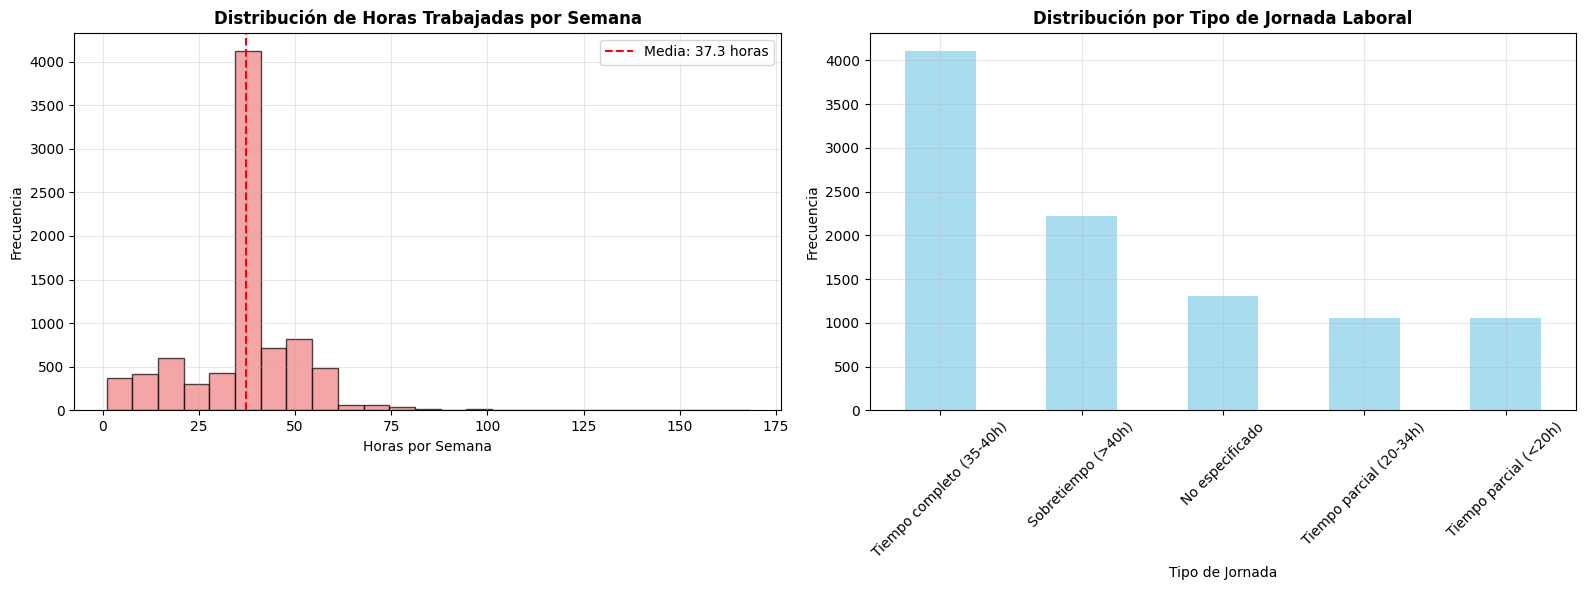


🔗 INTEGRACIÓN CON DATASET PRINCIPAL:
   Estadísticas de Número de Registros de Empleo por Persona:


,Estadística,Número_Registros_Empleo
0,Media,0.82
1,Mediana,1.00
2,Desv. Estándar,0.65
3,Mínimo,0.00
4,Máximo,5.00



✅ Análisis de historial laboral completado.
📊 Resumen: 9,751 registros de empleo de 8,338 individuos
⏰ Horas de trabajo: 8,447 registros válidos con promedio de 37.3 horas/semana


In [33]:
# 5.1 Análisis Detallado de Historial Laboral

print("=" * 80)
print("ANÁLISIS DE HISTORIAL LABORAL")
print("=" * 80)

# Extraer datos de empleo
empleo_data = []

for person_id, person_data in meps_data.items():
    historial_empleo = person_data.get('historial_empleo', [])
    
    for empleo in historial_empleo:
        if isinstance(empleo, dict):
            empleo_record = empleo.copy()
            empleo_record['person_id'] = person_id
            empleo_data.append(empleo_record)

# Crear DataFrame
df_empleo = pd.DataFrame(empleo_data)

print(f"📊 ESTADÍSTICAS GENERALES DE EMPLEO:")
print(f"   • Total de registros de empleo: {len(df_empleo):,}")
if not df_empleo.empty:
    print(f"   • Personas con historial laboral: {df_empleo['person_id'].nunique():,}")

if not df_empleo.empty:
    # 5.1.1 Análisis de Ofertas de Seguro por Empleador
    print(f"\n🏢 ANÁLISIS DE SEGUROS OFRECIDOS POR EMPLEADORES:")
    
    if 'seguro_ofrecido' in df_empleo.columns:
        seguro_emp_freq = df_empleo['seguro_ofrecido'].value_counts()
        seguro_emp_pct = (seguro_emp_freq / len(df_empleo) * 100).round(2)
        
        tabla_seguro_emp = pd.DataFrame({
            'Seguro_Ofrecido': seguro_emp_freq.index,
            'Frecuencia': seguro_emp_freq.values,
            'Porcentaje': seguro_emp_pct.values
        })
        
        print(f"   Distribución de Ofertas de Seguro por Empleador:")
        display(tabla_seguro_emp)
    
    # 5.1.2 Análisis de Tipo de Trabajo
    print(f"\n💼 ANÁLISIS DE CARACTERÍSTICAS DEL EMPLEO:")
    
    # Trabajo temporal
    if 'trabajo_temporal' in df_empleo.columns:
        temporal_freq = df_empleo['trabajo_temporal'].value_counts()
        temporal_pct = (temporal_freq / len(df_empleo) * 100).round(2)
        
        tabla_temporal = pd.DataFrame({
            'Trabajo_Temporal': temporal_freq.index,
            'Frecuencia': temporal_freq.values,
            'Porcentaje': temporal_pct.values
        })
        
        print(f"   Distribución por Tipo de Trabajo (Temporal vs Permanente):")
        display(tabla_temporal)
    
    # Empleado asalariado
    if 'empleado_asalariado' in df_empleo.columns:
        asalariado_freq = df_empleo['empleado_asalariado'].value_counts()
        asalariado_pct = (asalariado_freq / len(df_empleo) * 100).round(2)
        
        tabla_asalariado = pd.DataFrame({
            'Empleado_Asalariado': asalariado_freq.index,
            'Frecuencia': asalariado_freq.values,
            'Porcentaje': asalariado_pct.values
        })
        
        print(f"\n   Distribución por Tipo de Compensación:")
        display(tabla_asalariado)
    
    # 5.1.3 Análisis de Horas Trabajadas
    print(f"\n⏰ ANÁLISIS DE HORAS TRABAJADAS:")
    
    if 'horas_por_semana' in df_empleo.columns:
        # Convertir horas a numérico
        df_empleo['horas_numericas'] = pd.to_numeric(df_empleo['horas_por_semana'], errors='coerce')
        horas_validas = df_empleo['horas_numericas'].dropna()
        
        if len(horas_validas) > 0:
            print(f"   • Registros con horas válidas: {len(horas_validas):,} de {len(df_empleo):,} ({(len(horas_validas)/len(df_empleo)*100):.1f}%)")
            
            # Estadísticas descriptivas de horas
            stats_horas = horas_validas.describe()
            
            tabla_horas = pd.DataFrame({
                'Estadística': ['Media', 'Mediana', 'Desv. Estándar', 'Mínimo', 'Máximo', 'Q1 (25%)', 'Q3 (75%)'],
                'Horas_Semana': [
                    stats_horas['mean'],
                    stats_horas['50%'],
                    stats_horas['std'],
                    stats_horas['min'],
                    stats_horas['max'],
                    stats_horas['25%'],
                    stats_horas['75%']
                ]
            })
            tabla_horas['Horas_Semana'] = tabla_horas['Horas_Semana'].round(1)
            
            print(f"   Estadísticas Descriptivas de Horas por Semana:")
            display(tabla_horas)
            
            # Categorización de jornada laboral
            def categorizar_jornada(horas):
                if pd.isna(horas):
                    return 'No especificado'
                elif horas < 20:
                    return 'Tiempo parcial (<20h)'
                elif horas < 35:
                    return 'Tiempo parcial (20-34h)'
                elif horas <= 40:
                    return 'Tiempo completo (35-40h)'
                else:
                    return 'Sobretiempo (>40h)'
            
            df_empleo['categoria_jornada'] = df_empleo['horas_numericas'].apply(categorizar_jornada)
            jornada_freq = df_empleo['categoria_jornada'].value_counts()
            jornada_pct = (jornada_freq / len(df_empleo) * 100).round(2)
            
            tabla_jornada = pd.DataFrame({
                'Tipo_Jornada': jornada_freq.index,
                'Frecuencia': jornada_freq.values,
                'Porcentaje': jornada_pct.values
            })
            
            print(f"\n   Distribución por Tipo de Jornada Laboral:")
            display(tabla_jornada)
        
        else:
            print(f"   • No se encontraron horas válidas para análisis numérico")
    
    # 5.1.4 Análisis Temporal por Rounds
    print(f"\n📆 ANÁLISIS TEMPORAL DEL EMPLEO:")
    
    if 'round_reportado' in df_empleo.columns:
        rounds_empleo = df_empleo['round_reportado'].value_counts().sort_index()
        rounds_emp_pct = (rounds_empleo / len(df_empleo) * 100).round(2)
        
        tabla_rounds_empleo = pd.DataFrame({
            'Round': rounds_empleo.index,
            'Registros_Empleo': rounds_empleo.values,
            'Porcentaje': rounds_emp_pct.values
        })
        
        print(f"   Distribución de Registros de Empleo por Round:")
        display(tabla_rounds_empleo)
        
        # Análisis de horas promedio por round
        if len(horas_validas) > 0:
            horas_por_round = df_empleo.groupby('round_reportado')['horas_numericas'].agg(['mean', 'count']).round(1)
            horas_por_round.columns = ['Horas_Promedio', 'Num_Registros']
            
            print(f"\n   Horas Promedio Trabajadas por Round:")
            display(horas_por_round.reset_index())
    
    # 5.1.5 Análisis de Estabilidad Laboral
    print(f"\n📈 ANÁLISIS DE ESTABILIDAD LABORAL:")
    
    # Número de empleos por persona
    empleos_por_persona = df_empleo.groupby('person_id').size()
    
    stats_empleos = empleos_por_persona.describe()
    tabla_empleos_persona = pd.DataFrame({
        'Estadística': ['Media', 'Mediana', 'Desv. Estándar', 'Mínimo', 'Máximo'],
        'Número_Empleos': [
            stats_empleos['mean'],
            stats_empleos['50%'],
            stats_empleos['std'],
            stats_empleos['min'],
            stats_empleos['max']
        ]
    })
    tabla_empleos_persona['Número_Empleos'] = tabla_empleos_persona['Número_Empleos'].round(2)
    
    print(f"   Estadísticas de Número de Empleos por Persona:")
    display(tabla_empleos_persona)
    
    # Distribución de número de empleos
    dist_empleos = empleos_por_persona.value_counts().sort_index()
    dist_empleos_pct = (dist_empleos / len(empleos_por_persona) * 100).round(2)
    
    tabla_dist_empleos = pd.DataFrame({
        'Número_Empleos': dist_empleos.index,
        'Frecuencia_Personas': dist_empleos.values,
        'Porcentaje': dist_empleos_pct.values
    })
    
    print(f"\n   Distribución de Número de Empleos por Persona:")
    display(tabla_dist_empleos)

# Visualizaciones
if not df_empleo.empty and len(horas_validas) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histograma de horas trabajadas
    ax1.hist(horas_validas, bins=25, alpha=0.7, color='lightcoral', edgecolor='black')
    ax1.axvline(horas_validas.mean(), color='red', linestyle='--', 
                label=f'Media: {horas_validas.mean():.1f} horas')
    ax1.set_xlabel('Horas por Semana')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title('Distribución de Horas Trabajadas por Semana', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico de barras de jornada laboral
    if 'categoria_jornada' in df_empleo.columns:
        jornada_freq.plot(kind='bar', ax=ax2, color='skyblue', alpha=0.7)
        ax2.set_xlabel('Tipo de Jornada')
        ax2.set_ylabel('Frecuencia')
        ax2.set_title('Distribución por Tipo de Jornada Laboral', fontweight='bold')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Integración con datos principales
if 'num_empleos' in df_meps.columns:
    print(f"\n🔗 INTEGRACIÓN CON DATASET PRINCIPAL:")
    
    num_empleos_stats = df_meps['num_empleos'].describe()
    tabla_num_empleos = pd.DataFrame({
        'Estadística': ['Media', 'Mediana', 'Desv. Estándar', 'Mínimo', 'Máximo'],
        'Número_Registros_Empleo': [
            num_empleos_stats['mean'],
            num_empleos_stats['50%'],
            num_empleos_stats['std'],
            num_empleos_stats['min'],
            num_empleos_stats['max']
        ]
    })
    tabla_num_empleos['Número_Registros_Empleo'] = tabla_num_empleos['Número_Registros_Empleo'].round(2)
    
    print(f"   Estadísticas de Número de Registros de Empleo por Persona:")
    display(tabla_num_empleos)

print(f"\n✅ Análisis de historial laboral completado.")
if not df_empleo.empty:
    print(f"📊 Resumen: {len(df_empleo):,} registros de empleo de {df_empleo['person_id'].nunique():,} individuos")
    if len(horas_validas) > 0:
        print(f"⏰ Horas de trabajo: {len(horas_validas):,} registros válidos con promedio de {horas_validas.mean():.1f} horas/semana")
else:
    print(f"⚠️  No se encontraron datos de empleo para analizar")

## 6. Análisis de Correlaciones Completo

Esta sección presenta un análisis exhaustivo de las correlaciones entre todas las variables cuantitativas del dataset, identificando relaciones significativas que puedan influir en la predicción de primas out-of-pocket.

MATRIZ DE CORRELACIÓN - VARIABLES DEMOGRÁFICAS, ORIGINALES Y DERIVADAS
🔄 Extrayendo campos originales y calculando variables derivadas...
📊 Dataset para análisis de correlación:
   • Total de individuos: 11,852
   • Total de campos: 17

📋 Variables para correlación: 16
   Variables disponibles: ['edad', 'sexo_num', 'raza_etnicidad_num', 'estado_civil_num', 'region_num', 'categoria_pobreza_num', 'cobertura_seguro_num', 'estado_salud_percibido_num', 'gastos_medicos_totales', 'gastos_out_of_pocket', 'peso_persona', 'cantidad_empleos', 'cantidad_condiciones_medicas', 'cantidad_seguros_medicos', 'horas_trabajadas_promedio', 'prima_out_of_pocket_editada']

🔍 MATRIZ DE CORRELACIÓN:
   Dimensiones: 16 x 16
   Individuos con datos completos: 1,569


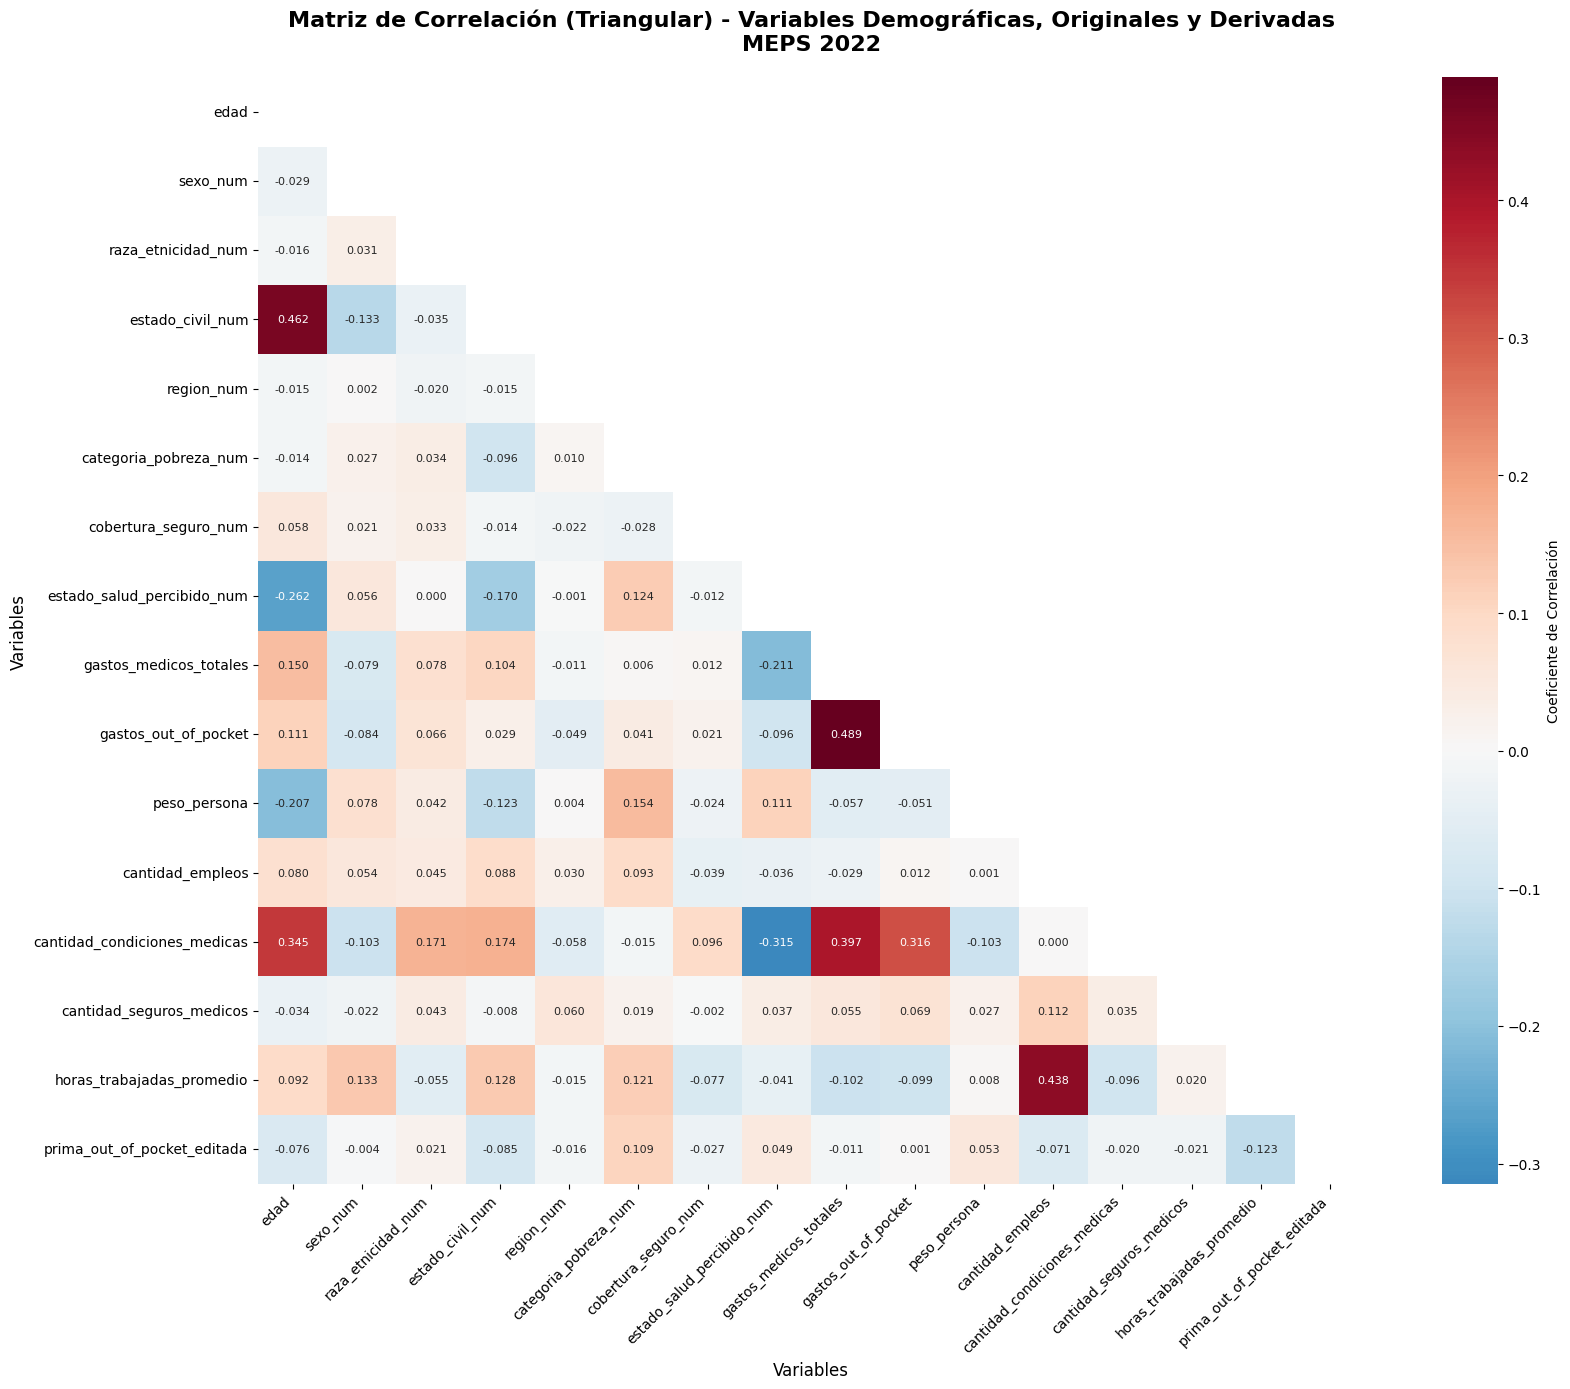


✅ Matriz de correlación generada exitosamente.
📊 Incluye 16 variables (demográficas + originales + derivadas + prima editada)


In [34]:
# 6.1 Matriz de Correlación - Variables Demográficas, Originales y Derivadas

print("=" * 80)
print("MATRIZ DE CORRELACIÓN - VARIABLES DEMOGRÁFICAS, ORIGINALES Y DERIVADAS")
print("=" * 80)

# Crear dataset con campos originales del JSON y variables derivadas
print("🔄 Extrayendo campos originales y calculando variables derivadas...")

json_records = []

for person_id, person_data in meps_data.items():
    record = {'person_id': person_id}
    
    # Solo campos del nivel superior del JSON (no listas)
    for key, value in person_data.items():
        if not isinstance(value, list):  # Excluir listas como condiciones_medicas, historial_empleo, etc.
            record[key] = value
    
    # Calcular variables derivadas
    
    # 1. Cantidad total de empleos
    if 'historial_empleo' in person_data and person_data['historial_empleo']:
        record['cantidad_empleos'] = len(person_data['historial_empleo'])
    else:
        record['cantidad_empleos'] = 0
    
    # 2. Cantidad de condiciones médicas
    if 'condiciones_medicas' in person_data and person_data['condiciones_medicas']:
        record['cantidad_condiciones_medicas'] = len(person_data['condiciones_medicas'])
    else:
        record['cantidad_condiciones_medicas'] = 0
    
    # 3. Cantidad de seguros médicos
    if 'historial_seguros' in person_data and person_data['historial_seguros']:
        record['cantidad_seguros_medicos'] = len(person_data['historial_seguros'])
    else:
        record['cantidad_seguros_medicos'] = 0
    
    # 4. Horas trabajadas promedio
    if 'historial_empleo' in person_data and person_data['historial_empleo']:
        total_horas = 0
        empleos_con_horas = 0
        
        for empleo in person_data['historial_empleo']:
            if 'horas_por_semana' in empleo and empleo['horas_por_semana'] not in ['Inapplicable', None]:
                try:
                    horas = float(empleo['horas_por_semana'])
                    total_horas += horas
                    empleos_con_horas += 1
                except (ValueError, TypeError):
                    pass
        
        record['horas_trabajadas_promedio'] = total_horas / empleos_con_horas if empleos_con_horas > 0 else 0
    else:
        record['horas_trabajadas_promedio'] = 0
    
    # 5. Prima out-of-pocket editada (si existe en algún seguro)
    if 'historial_seguros' in person_data and person_data['historial_seguros']:
        primas_editadas = []
        
        for seguro in person_data['historial_seguros']:
            if 'prima_out_of_pocket_editada' in seguro and seguro['prima_out_of_pocket_editada'] not in ['Inapplicable', None]:
                try:
                    prima = float(seguro['prima_out_of_pocket_editada'])
                    primas_editadas.append(prima)
                except (ValueError, TypeError):
                    pass
        
        record['prima_out_of_pocket_editada'] = sum(primas_editadas) / len(primas_editadas) if primas_editadas else 0
    else:
        record['prima_out_of_pocket_editada'] = 0
    
    json_records.append(record)

# Crear DataFrame con campos originales y variables derivadas
df_correlacion = pd.DataFrame(json_records)

print(f"📊 Dataset para análisis de correlación:")
print(f"   • Total de individuos: {len(df_correlacion):,}")
print(f"   • Total de campos: {len(df_correlacion.columns)}")

# Convertir variables categóricas a numéricas
# Cobertura de seguro
if 'cobertura_seguro' in df_correlacion.columns:
    df_correlacion['cobertura_seguro_num'] = df_correlacion['cobertura_seguro'].map({
        'Any private': 1,
        'Public only': 2,
        'Uninsured': 0
    })

# Estado de salud percibido
if 'estado_salud_percibido' in df_correlacion.columns:
    df_correlacion['estado_salud_percibido_num'] = df_correlacion['estado_salud_percibido'].map({
        'Excellent': 5,
        'Very good': 4,
        'Good': 3,
        'Fair': 2,
        'Poor': 1
    })

# Sexo
if 'sexo' in df_correlacion.columns:
    df_correlacion['sexo_num'] = df_correlacion['sexo'].map({
        'Male': 1,
        'Female': 0
    })

# Región
if 'region' in df_correlacion.columns:
    df_correlacion['region_num'] = df_correlacion['region'].map({
        'Northeast': 1,
        'Midwest': 2,
        'South': 3,
        'West': 4
    })

# Estado civil
if 'estado_civil' in df_correlacion.columns:
    df_correlacion['estado_civil_num'] = df_correlacion['estado_civil'].map({
        'Never married': 1,
        'Married': 2,
        'Widowed': 3,
        'Divorced': 4,
        'Separated': 5
    })

# Raza/etnicidad
if 'raza_etnicidad' in df_correlacion.columns:
    df_correlacion['raza_etnicidad_num'] = df_correlacion['raza_etnicidad'].map({
        'Hispanic': 1,
        'Non-Hispanic White': 2,
        'Non-Hispanic Black': 3,
        'Non-Hispanic Asian': 4,
        'Non-Hispanic Other race or multi-race': 5
    })

# Categoría de pobreza
if 'categoria_pobreza' in df_correlacion.columns:
    df_correlacion['categoria_pobreza_num'] = df_correlacion['categoria_pobreza'].map({
        'Poor': 1,
        'Near poor': 2,
        'Low income': 3,
        'Middle income': 4,
        'High income': 5
    })

# Seleccionar variables para correlación
variables_para_correlacion = [
    # Variables demográficas numéricas originales
    'edad',
    # Variables demográficas codificadas
    'sexo_num',
    'raza_etnicidad_num',
    'estado_civil_num',
    'region_num',
    'categoria_pobreza_num',
    # Variables de salud y seguros
    'cobertura_seguro_num',
    'estado_salud_percibido_num',
    'gastos_medicos_totales',
    'gastos_out_of_pocket',
    'peso_persona',
    # Variables derivadas
    'cantidad_empleos',
    'cantidad_condiciones_medicas',
    'cantidad_seguros_medicos',
    'horas_trabajadas_promedio',
    'prima_out_of_pocket_editada'
]

# Filtrar solo las variables que existen en el DataFrame
variables_disponibles = [var for var in variables_para_correlacion if var in df_correlacion.columns]

print(f"\n📋 Variables para correlación: {len(variables_disponibles)}")
print(f"   Variables disponibles: {variables_disponibles}")

# Crear matriz de correlación
if len(variables_disponibles) >= 2:
    # Filtrar datos válidos
    df_para_correlacion = df_correlacion[variables_disponibles].dropna()
    
    if len(df_para_correlacion) > 0:
        matriz_correlacion = df_para_correlacion.corr()
        
        print(f"\n🔍 MATRIZ DE CORRELACIÓN:")
        print(f"   Dimensiones: {matriz_correlacion.shape[0]} x {matriz_correlacion.shape[1]}")
        print(f"   Individuos con datos completos: {len(df_para_correlacion):,}")
        
        # Visualización triangular de la matriz de correlación
        plt.figure(figsize=(18, 14))
        
        # Crear máscara para el triángulo superior (incluyendo diagonal)
        mask = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
        
        # Heatmap triangular
        sns.heatmap(matriz_correlacion, 
                    mask=mask,
                    annot=True, 
                    cmap='RdBu_r', 
                    center=0,
                    square=True,
                    fmt='.3f',
                    cbar_kws={'label': 'Coeficiente de Correlación'},
                    annot_kws={'size': 8})
        
        plt.title('Matriz de Correlación (Triangular) - Variables Demográficas, Originales y Derivadas\nMEPS 2022', 
                  fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Variables', fontsize=12)
        plt.ylabel('Variables', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        print(f"\n✅ Matriz de correlación generada exitosamente.")
        print(f"📊 Incluye {len(variables_disponibles)} variables (demográficas + originales + derivadas + prima editada)")
    else:
        print(f"❌ No hay datos válidos después del filtrado")
        
else:
    print(f"❌ No se encontraron suficientes variables numéricas")
    print(f"   Variables disponibles: {variables_disponibles}")

## Análisis de Importancia de Enfermedades Específicas

Para determinar si es necesario considerar enfermedades específicas individualmente o si podemos resumirlas, utilizaremos varias técnicas:

1. **Análisis de Correlación**: Correlación entre enfermedades específicas y la prima de seguro
2. **Análisis de Varianza (ANOVA)**: Diferencias significativas en primas entre grupos con/sin enfermedades específicas
3. **Análisis de Frecuencia**: Identificar las enfermedades más comunes y su impacto
4. **Mutual Information**: Información mutua entre enfermedades específicas y la variable objetivo

Esto nos ayudará a decidir si mantener enfermedades específicas como características individuales o si agruparlas es suficiente.

Analizando importancia de enfermedades específicas...
Total de snapshots: 11852

Enfermedades más comunes:
Essential hypertension                                                2350
Disorders of lipid metabolism                                         1780
Diabetes mellitus without complication                                 879
Anxiety and fear-related disorders                                     872
Categoría médica no especificada                                       806
Exposure, encounters, screening or contact with infectious disease     740
Musculoskeletal pain, not low back pain                                736
Depressive disorders                                                   713
Asthma                                                                 685
Thyroid disorders                                                      655
Osteoarthritis                                                         571
Esophageal disorders                                                

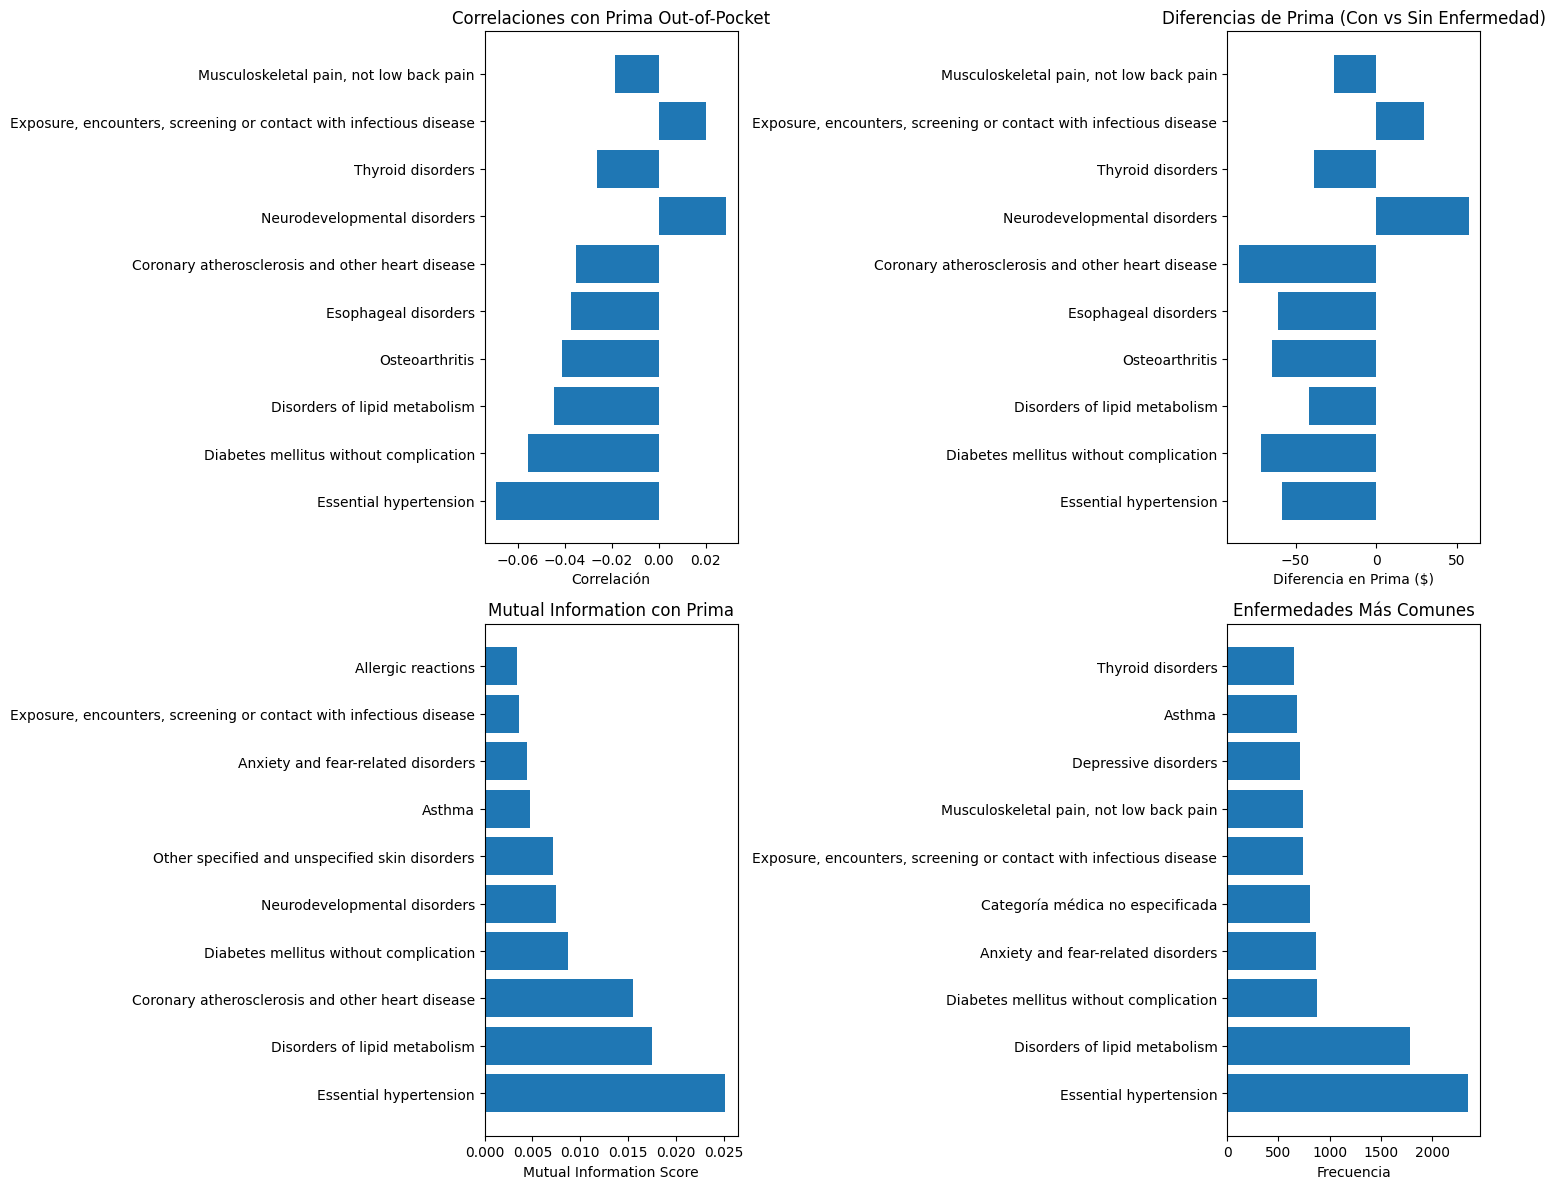


=== RESUMEN Y RECOMENDACIONES ===
Enfermedades analizadas: 20
Enfermedades con correlación |r| > 0.1: 0
Enfermedades con diferencias significativas (p < 0.05): 10
Enfermedades con MI > 0.01: 3

Enfermedades identificadas como importantes: 10
Lista de enfermedades importantes:
- Coronary atherosclerosis and other heart disease
- Diabetes mellitus without complication
- Disorders of lipid metabolism
- Esophageal disorders
- Essential hypertension
- Exposure, encounters, screening or contact with infectious disease
- Musculoskeletal pain, not low back pain
- Neurodevelopmental disorders
- Osteoarthritis
- Thyroid disorders

⚠️ RECOMENDACIÓN: Considerar agrupar enfermedades
   El número de enfermedades importantes es alto, considerar:
   - Agrupar por categorías (mental health, cardiovascular, etc.)
   - Usar solo un resumen (número de condiciones, cronicidad)
   - Seleccionar solo las top 5-10 más importantes


In [35]:
# 7. Análisis de Importancia de Enfermedades Específicas

# Cargar datos de snapshots
import json
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar snapshots
with open('../Feature Engineering/snapshots.json', 'r', encoding='utf-8') as f:
    snapshots = json.load(f)

# Crear DataFrame
df_snapshots = pd.DataFrame(snapshots)

# Expandir condiciones médicas para análisis
print("Analizando importancia de enfermedades específicas...")
print(f"Total de snapshots: {len(df_snapshots)}")

# 1. Análisis de frecuencia de enfermedades
all_diseases = []
for snapshot in snapshots:
    for condition in snapshot['condiciones_medicas']:
        all_diseases.append(condition['descripcion_ccsr'])

disease_counts = pd.Series(all_diseases).value_counts()
print(f"\nEnfermedades más comunes:")
print(disease_counts.head(15))

# 2. Crear matriz de enfermedades específicas vs prima
# Obtener las 20 enfermedades más comunes
top_diseases = disease_counts.head(20).index.tolist()

# Crear DataFrame con enfermedades como columnas binarias
disease_matrix = []
primas = []

for snapshot in snapshots:
    # Obtener enfermedades de este snapshot
    snapshot_diseases = [cond['descripcion_ccsr'] for cond in snapshot['condiciones_medicas']]
    
    # Crear fila binaria para cada enfermedad
    row = {disease: 1 if disease in snapshot_diseases else 0 for disease in top_diseases}
    
    # Agregar información adicional
    row['prima_out_of_pocket_editada'] = float(snapshot['seguro']['prima_out_of_pocket_editada'])
    row['edad'] = snapshot['edad']
    row['num_condiciones'] = len(snapshot['condiciones_medicas'])
    
    disease_matrix.append(row)
    primas.append(float(snapshot['seguro']['prima_out_of_pocket_editada']))

df_diseases = pd.DataFrame(disease_matrix)
print(f"\nMatriz de enfermedades creada: {df_diseases.shape}")

# 3. Análisis de correlación entre enfermedades específicas y prima
print("\n=== ANÁLISIS DE CORRELACIÓN ===")
correlations = []
for disease in top_diseases:
    corr = df_diseases[disease].corr(df_diseases['prima_out_of_pocket_editada'])
    correlations.append({'enfermedad': disease, 'correlacion': corr})

correlation_df = pd.DataFrame(correlations).sort_values('correlacion', key=abs, ascending=False)
print("Correlaciones más fuertes con prima out-of-pocket:")
print(correlation_df.head(10))

# 4. Análisis ANOVA - Diferencias significativas en primas
print("\n=== ANÁLISIS ANOVA ===")
anova_results = []
for disease in top_diseases:
    # Dividir en grupos con y sin la enfermedad
    with_disease = df_diseases[df_diseases[disease] == 1]['prima_out_of_pocket_editada']
    without_disease = df_diseases[df_diseases[disease] == 0]['prima_out_of_pocket_editada']
    
    if len(with_disease) > 5 and len(without_disease) > 5:  # Asegurar suficientes datos
        # Realizar t-test
        t_stat, p_value = stats.ttest_ind(with_disease, without_disease)
        
        # Calcular diferencia de medias
        mean_with = with_disease.mean()
        mean_without = without_disease.mean()
        diff = mean_with - mean_without
        
        anova_results.append({
            'enfermedad': disease,
            'media_con_enfermedad': mean_with,
            'media_sin_enfermedad': mean_without,
            'diferencia': diff,
            'p_valor': p_value,
            'significativo': p_value < 0.05
        })

anova_df = pd.DataFrame(anova_results).sort_values('p_valor')
print("Enfermedades con diferencias significativas en primas:")
print(anova_df[anova_df['significativo']].head(10))

# 5. Mutual Information
print("\n=== MUTUAL INFORMATION ===")
X_diseases = df_diseases[top_diseases]
y_prima = df_diseases['prima_out_of_pocket_editada']

# Calcular mutual information
mi_scores = mutual_info_regression(X_diseases, y_prima, random_state=42)
mi_results = pd.DataFrame({
    'enfermedad': top_diseases,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)

print("Mutual Information con prima out-of-pocket:")
print(mi_results.head(10))

# 6. Visualización de resultados
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Correlaciones
axes[0, 0].barh(correlation_df.head(10)['enfermedad'], correlation_df.head(10)['correlacion'])
axes[0, 0].set_title('Correlaciones con Prima Out-of-Pocket')
axes[0, 0].set_xlabel('Correlación')

# Diferencias de medias (ANOVA)
significant_anova = anova_df[anova_df['significativo']].head(10)
axes[0, 1].barh(significant_anova['enfermedad'], significant_anova['diferencia'])
axes[0, 1].set_title('Diferencias de Prima (Con vs Sin Enfermedad)')
axes[0, 1].set_xlabel('Diferencia en Prima ($)')

# Mutual Information
axes[1, 0].barh(mi_results.head(10)['enfermedad'], mi_results.head(10)['mutual_info'])
axes[1, 0].set_title('Mutual Information con Prima')
axes[1, 0].set_xlabel('Mutual Information Score')

# Frecuencia de enfermedades
axes[1, 1].barh(disease_counts.head(10).index, disease_counts.head(10).values)
axes[1, 1].set_title('Enfermedades Más Comunes')
axes[1, 1].set_xlabel('Frecuencia')

plt.tight_layout()
plt.show()

# 7. Resumen y recomendaciones
print("\n=== RESUMEN Y RECOMENDACIONES ===")
print(f"Enfermedades analizadas: {len(top_diseases)}")
print(f"Enfermedades con correlación |r| > 0.1: {len(correlation_df[abs(correlation_df['correlacion']) > 0.1])}")
print(f"Enfermedades con diferencias significativas (p < 0.05): {len(anova_df[anova_df['significativo']])}")
print(f"Enfermedades con MI > 0.01: {len(mi_results[mi_results['mutual_info'] > 0.01])}")

# Identificar enfermedades importantes
important_diseases = set()
# Agregar por correlación
important_diseases.update(correlation_df[abs(correlation_df['correlacion']) > 0.1]['enfermedad'].tolist())
# Agregar por ANOVA
important_diseases.update(anova_df[anova_df['significativo']]['enfermedad'].tolist())
# Agregar por MI
important_diseases.update(mi_results[mi_results['mutual_info'] > 0.01]['enfermedad'].tolist())

print(f"\nEnfermedades identificadas como importantes: {len(important_diseases)}")
print("Lista de enfermedades importantes:")
for disease in sorted(important_diseases):
    print(f"- {disease}")

if len(important_diseases) < 10:
    print("\n✅ RECOMENDACIÓN: Considerar enfermedades específicas individualmente")
    print("   El número de enfermedades importantes es manejable.")
else:
    print("\n⚠️ RECOMENDACIÓN: Considerar agrupar enfermedades")
    print("   El número de enfermedades importantes es alto, considerar:")
    print("   - Agrupar por categorías (mental health, cardiovascular, etc.)")
    print("   - Usar solo un resumen (número de condiciones, cronicidad)")
    print("   - Seleccionar solo las top 5-10 más importantes")